# Diffusion motion correction tutorial

Start by importing the required libraries and defining some settings:

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.diffusion import ADC, DTI
from ukat.moco.mdr import MotionCorrection

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
directory = 'diffusion_motion_correction_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

In [2]:
# Fetch test data
pixel_array, affine, bvals, bvecs = fetch.dwi_philips()
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters = [affine, bvals, None, False]

In [3]:
# Model-driven registration
registration = MotionCorrection(pixel_array, affine, 'DWI_Moco', list_input_parameters, convergence=1, multithread=True, log=False)
registration.run()

Co-registration progress: 100%|██████████| 79/79 [02:35<00:00,  1.97s/it]


In [4]:
# Get the coregistered input pixel_array
moco_array = registration.get_coregistered()
# Save motion corrected diffusion sequence to NIfTI
registration.to_nifti(output_directory=OUTPUT_DIR, base_file_name='DWI_motion_corrected', maps=['coregistered', 'fitted', 'deformation_field', 'params'])

In [5]:
# Generate a mask based on the intensity of the b0 volume. This will reduce computation times.
mask = pixel_array[..., 0] > 20000

# Calculate maps from the original diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps='all')

# Calculate maps from the original diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps=['md', 'fa'])

# Calculate maps from the motion corrected diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(moco_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps='all')

# Calculate maps from the motion corrected diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(moco_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps=['md', 'fa'])

100%|██████████| 57103/57103 [00:08<00:00, 6530.37it/s]


(-0.5, 127.5, 127.5, -0.5)

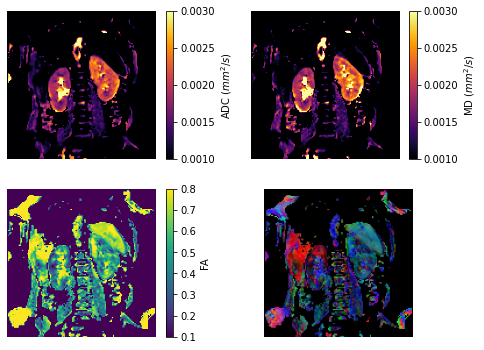

In [6]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')